In [35]:
import matplotlib.pyplot as plt
import torch
import random
import numpy as np
import os
import cv2
import torchvision.models as models
import torchvision
import warnings
from torchvision import transforms
from IPython.display import clear_output
from torch import nn, optim
from tqdm.auto import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
# from google.colab import drive
# from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
from torch.utils.data import Subset
# from torchsummary import summary

warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed=42):
    # Устанавливаем сид для PyTorch
    torch.manual_seed(seed)
    # Если вы используете CUDA (GPU)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Если используется более одного GPU
    # Устанавливаем сид для numpy (например, используется в Dataloader)
    np.random.seed(seed)
    # Устанавливаем сид для стандартной библиотеки Python random
    random.seed(seed)
    # Настраиваем PyTorch на детерминистичный режим
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [3]:
# drive.mount('/content/drive')

In [4]:
torch.cuda.is_available()
device = 'cuda'

In [5]:
path_to_images = 'C:/Users/senia/Desktop/wb sphere analysis/images/'

In [6]:
folds = ['0', '1']

def image_size_detector(folders, path_from_cur_dir):
    for main_folder in folders:
        images_folder = os.path.join(path_from_cur_dir, main_folder)
        print(f'Folder: {images_folder}')
        image_sizes = []
        if os.path.exists(images_folder):
            for root, _, files in os.walk(images_folder):
                for file in files:
                    if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                        file_path = os.path.join(root, file)
                        img = cv2.imread(file_path)
                        if img is not None:
                            height, width, _ = img.shape
                            image_sizes.append((width, height))
            if image_sizes:
                print(f'Number of images: {len(image_sizes)}')
                print(f'Minimum image size: {min(image_sizes)}')
                print(f'Maximum image size: {max(image_sizes)}')

            else:
                print('No images found in this folder.')
        else:
            print(f'No images folder found in {main_folder}')
        print()

image_size_detector(folds, path_to_images)

Folder: C:/Users/senia/Desktop/wb sphere analysis/images/0
Number of images: 451
Minimum image size: (900, 1200)
Maximum image size: (900, 1200)

Folder: C:/Users/senia/Desktop/wb sphere analysis/images/1
Number of images: 681
Minimum image size: (900, 1200)
Maximum image size: (900, 1200)



['C:/Users/senia/Desktop/wb sphere analysis/images//0\\0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\10.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\100.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\101.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\102.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\103.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\104.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\105.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\106.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\107.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\108.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\109.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\11.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//0\\110.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/im

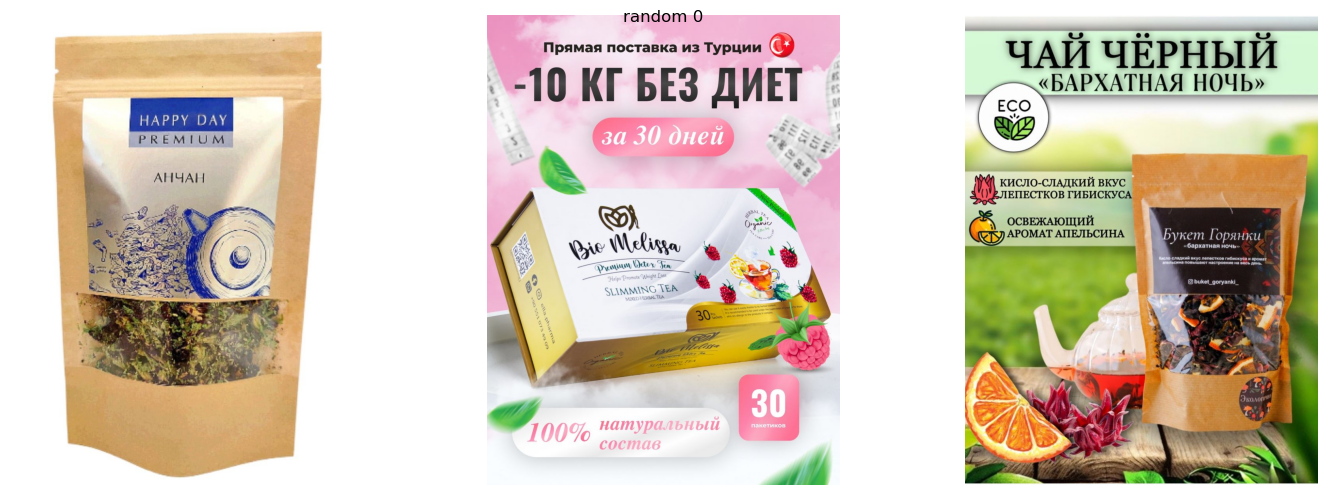

['C:/Users/senia/Desktop/wb sphere analysis/images//1\\0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1000.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1001.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1002.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1005.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1009.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\101.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1010.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1013.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1014.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1016.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1017.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1023.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images//1\\1025.jpg', 'C:/Users/senia/Desktop/wb sphe

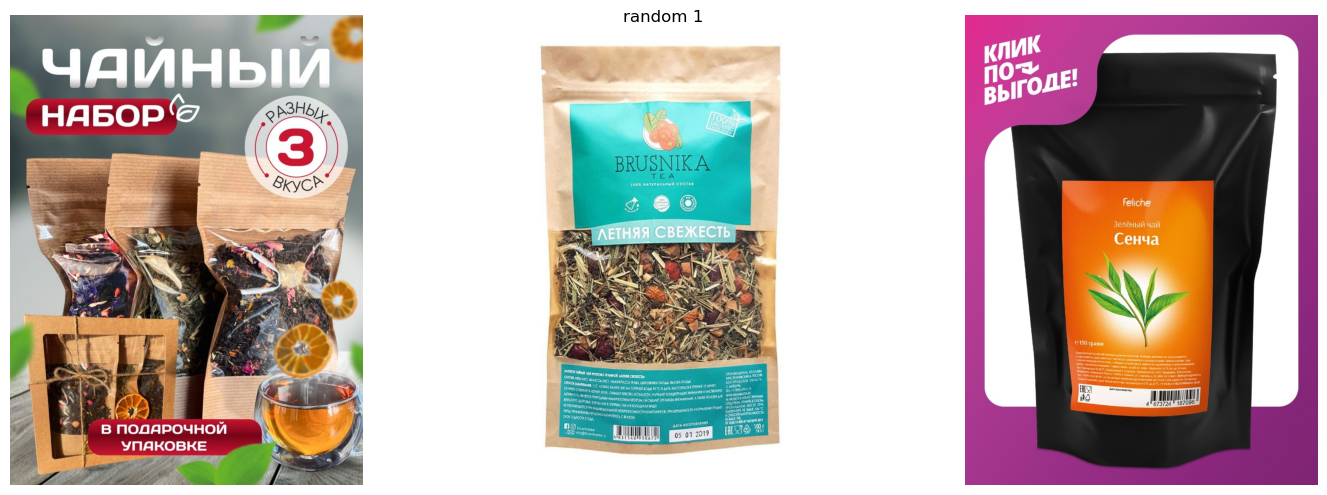

In [7]:
for folder in folds:
    folder_path = f'{path_to_images}/{folder}'

    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
    print(image_files)
    random_images = random.sample(image_files, 3)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, image_path in enumerate(random_images):
        image = cv2.imread(image_path)
        if image is not None:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i].imshow(image_rgb)
            axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle(f'random {folder}')
    plt.show()


In [8]:
#initialize our transformations
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=226, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224,224)),

        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=226),
        transforms.CenterCrop(size=254),
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.Resize(size=226),
        transforms.CenterCrop(size=254),
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
}

def preprocess(
        data_path,
        transform,
        train_size=.7,
        test_size=.2,
        batch_size=16,
        seed = 42
        ):

    seed = seed
    torch.manual_seed(seed)
    random.seed(seed)

    train_dataset = ImageFolder(root=data_path, transform=transform['train'])
    test_dataset = ImageFolder(root=data_path, transform=transform['test'])
    val_dataset = ImageFolder(root=data_path, transform=transform['val'])


    total_size = len(train_dataset)
    train_size = int(total_size * train_size)
    test_size = int(total_size * test_size)

    indices = torch.randperm(total_size).tolist()
    train_indices = indices[:train_size]
    test_indices = indices[train_size:train_size + test_size]
    val_indices = indices[train_size + test_size:]

    # Создаем subset-ы
    train_subset = torch.utils.data.Subset(train_dataset, train_indices)
    test_subset = torch.utils.data.Subset(test_dataset, test_indices)
    val_subset = torch.utils.data.Subset(val_dataset, val_indices)

    # Создаем DataLoader-ы
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    print(train_dataset.classes)
    return train_loader, test_loader, val_loader

In [9]:
train_loader, test_loader, val_loader = preprocess(path_to_images, transform, batch_size=32)

def count_classes(loader):
    class_counts = {
        0: 0,
        1: 0
    }

    for images, labels in loader:
        for label in labels.tolist():
            if label not in class_counts:
                class_counts[label] = 1
            else:
                class_counts[label] += 1

    sorted_counts = {k: v for k, v in sorted(class_counts.items())}
    return sorted_counts

def calculate_percentages(train_class_counts, val_class_counts, test_class_counts):
    percentages = {}
    for k, v in enumerate(train_class_counts):
        sm = train_class_counts[k] + val_class_counts[k] + test_class_counts[k]

        train_p = round(train_class_counts[k] * 100 / sm, 2)
        val_p = round(val_class_counts[k] * 100 / sm, 2)
        test_p = round(test_class_counts[k] * 100 / sm, 2)

        percentages[k] = {
            'train': train_p,
            'test': test_p,
            'val': val_p
        }

    return percentages

# Check class counts and percentages for train_loader, val_loader, and test_loader
train_class_counts = count_classes(train_loader)
val_class_counts = count_classes(val_loader)
test_class_counts = count_classes(test_loader)

print('Class counts in train_loader:', train_class_counts)
print('Class counts in val_loader:', val_class_counts)
print('Class counts in test_loader:', test_class_counts)

percentages = calculate_percentages(train_class_counts, val_class_counts, test_class_counts)
print('Each class percentage:', percentages)


['0', '1']
Class counts in train_loader: {0: 319, 1: 473}
Class counts in val_loader: {0: 44, 1: 70}
Class counts in test_loader: {0: 88, 1: 138}
Each class percentage: {0: {'train': 70.73, 'test': 19.51, 'val': 9.76}, 1: {'train': 69.46, 'test': 20.26, 'val': 10.28}}


In [10]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

## transfer learning

In [11]:
# use GPU
device = 'cuda'

In [12]:
# create function that plots training cycle
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2
    )
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [13]:
# training function creation
def train_nn(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5, verbose=False, scheduler_gamma=1):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    train_f1_log, train_f1_glob_log, val_f1_log, val_f1_glob_log= [], [], [], []
    l1_lambda = 0.00001
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=scheduler_gamma)
    
    with open('cv_quality.txt', 'r') as f:
        metric = float(f.read())
    for epoch in range(n_epochs):
        # training

        train_epoch_loss, train_epoch_true_hits  = torch.empty(0), torch.empty(0)
        train_epoch_f1, train_epoch_f1_glob = [], []
        all_train_preds, all_train_labels = [], []
        all_val_probs = []

        model.train()
        for imgs, labels in tqdm(
            train_dataloader, desc=f"Training, epoch {epoch}, lr: {optimizer.param_groups[0]['lr']}", leave=False
        ):
            imgs, labels = imgs.to(device), labels.to(device)
            
            y_pred = model(imgs)


            loss = criterion(y_pred, labels)
                # Calculate L1 penalty
            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            total_loss = loss + l1_lambda * l1_penalty
            total_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
            )
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append((pred_classes == labels.cpu()).sum() / labels.cpu().shape[0])

            train_epoch_f1.append(f1_score(labels.cpu(), pred_classes, average='weighted'))
            train_f1_log.append(torch.tensor(train_epoch_f1).mean().item())

            all_train_preds.extend(pred_classes.cpu().tolist())
            all_train_labels.extend(labels.cpu().tolist())


            train_epoch_f1_glob.append(f1_score(all_train_labels, all_train_preds, average='weighted'))
            train_f1_glob_log.append(torch.tensor(train_epoch_f1_glob).mean().item())


        scheduler.step()

        # validation
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        val_epoch_f1, val_epoch_f1_glob = [], []
        all_val_preds, all_val_labels = [], []

        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(
                val_dataloader, desc=f"Validating, epoch {epoch}", leave=False
            ):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                y_probs = torch.softmax(y_pred, dim=1)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
                )

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                all_val_probs.append(y_probs.cpu())
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

                val_epoch_f1.append(f1_score(labels.cpu(), pred_classes, average='weighted'))
                val_f1_log.append(torch.tensor(val_epoch_f1).mean().item())


                all_val_preds.extend(pred_classes.cpu().tolist())
                all_val_labels.extend(labels.cpu().tolist())

                val_epoch_f1_glob.append(f1_score(all_val_labels, all_val_preds, average='weighted'))
                val_f1_glob_log.append(torch.tensor(val_epoch_f1_glob).mean().item())

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum()
            / val_epoch_true_hits.size(0)
            / val_dataloader.batch_size
        )
        clear_output()
        all_val_probs = torch.cat(all_val_probs).numpy()
        roc_auc = roc_auc_score(all_val_labels, all_val_probs[:, 1])

        fnl_loss_train = train_epoch_loss.mean().item()
        fnl_loss_val = val_epoch_loss.mean().item()
        fnl_f1_train = torch.tensor(train_epoch_f1).mean().item()
        fnl_f1_val = torch.tensor(val_epoch_f1).mean().item()
        fnl_f1_glob_train = torch.tensor(train_epoch_f1_glob).mean().item()
        fnl_f1_glob_val = torch.tensor(val_epoch_f1_glob).mean().item()
        fnl_acc_train = (
                    train_epoch_true_hits.sum()
                    / train_epoch_true_hits.size(0)
                    / train_dataloader.batch_size
                ).item()
        fnl_acc_val =                 (
                    val_epoch_true_hits.sum()
                    / val_epoch_true_hits.size(0)
                    / val_dataloader.batch_size
                ).item()
        
        if fnl_acc_val > metric:
            metric = fnl_acc_val 
            model.to('cpu')
            torch.save(model, f'C:/Users/senia/Desktop/wb sphere analysis/wb-category-analysis/models/cv{model.__class__.__name__}.pth')
            with open('C:/Users/senia/Desktop/wb sphere analysis/wb-category-analysis/models/cv_quality.txt', 'w') as f:
                f.write(str(metric))
            
            model.to(device)

        if verbose:
            # plot_history(train_loss_log, val_loss_log, "loss")
            # plot_history(train_acc_log, val_acc_log, "accuracy")
            # plot_history(train_f1_log, val_f1_log, "f1")
            # plot_history(train_f1_glob_log, val_f1_glob_log, "f1 global")
            print("Train loss:", fnl_loss_train)
            print("Train acc:", fnl_acc_train)
            print("Train f1:", fnl_f1_train)
            print("Train f1 global:", fnl_f1_glob_train)
            print("Val loss:", fnl_loss_val)
            print("Val acc:", fnl_acc_val)
            print("Val f1:", fnl_f1_val)
            print("Val f1 global:", fnl_f1_glob_val)
            print("Val ROC AUC:", roc_auc)
        

    return fnl_loss_train, fnl_acc_train, fnl_f1_train, fnl_f1_glob_train, fnl_loss_val, fnl_acc_val, fnl_f1_val, fnl_f1_glob_val, val_acc_log, train_acc_log

In [14]:
def train(
        train_loader,
        val_loader,
        optimizer=optim.SGD,
        loss=nn.CrossEntropyLoss,
        model=models.resnet50(pretrained=True),
        learning_rate=.001,
        n_epochs=5,
        scheduler_gamma=1,
        verbose=False,
        weight_decay=0
        ):

    md = model.to(device)
    # weights = torch.tensor([1.64, 0.72]).float()
    # weights.to(device)
    # criterion = loss(weight=weights).to(device)
    criterion = loss()
    opt = optimizer(md.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob, val_acc_log, train_acc_log = train_nn(
        md,
        criterion,
        opt,
        train_loader,
        val_loader,
        verbose=verbose,
        n_epochs=n_epochs,
        scheduler_gamma=scheduler_gamma)

    return train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob, val_acc_log, train_acc_log

In [15]:
train_load, test_load, val_load = preprocess(path_to_images, transform, batch_size=32)

['0', '1']


In [16]:
# lr = [.1, .0001, .005, .0005]

# results = {}
# for l in lr:
#     train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
#         train_load,
#         val_load,
#         learning_rate=l
#     )
#     results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
# results

In [16]:
model = models.resnet34(pretrained=True)

# for param in model.parameters():
#   param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    # nn.Linear(1024, 256),
    # nn.ReLU(),
    # nn.Dropout(0.2),
    nn.Linear(1024, 2)
)

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None , reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')  # We'll modify this loss

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        pt = torch.exp(-ce_loss)  # Probability of being correct
        F_loss = (self.alpha * (1-pt)**self.gamma * ce_loss) if self.alpha is not None else ((1-pt)**self.gamma * ce_loss)

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [31]:
lr = [0.00007]

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob, val_acc_log, train_acc_log = train(
        train_load,
        val_load,
        learning_rate=l,
        model=model,
        optimizer=optim.Adam,
        n_epochs=12,
        verbose=True,
        scheduler_gamma=1,
        # loss = FocalLoss,
        weight_decay=1e-4
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob, train_acc_log, val_acc_log)
print(results)
print(train_acc_log)
print(val_acc_log)

Train loss: 0.0013827553484588861
Train acc: 0.9762499928474426
Train f1: 0.9863311983119118
Train f1 global: 0.9870811676973891
Val loss: 0.03707713633775711
Val acc: 0.6953125
Val f1: 0.7728511692443294
Val f1 global: 0.7465537027470892
Val ROC AUC: 0.8373376623376623
{7e-05: (0.0013827553484588861, 0.9762499928474426, 0.9863311983119118, 0.9870811676973891, 0.03707713633775711, 0.6953125, 0.7728511692443294, 0.7465537027470892, [tensor(0.5312), tensor(0.6562), tensor(0.5312), tensor(0.4688), tensor(0.7188), tensor(0.5938), tensor(0.7812), tensor(0.6875), tensor(0.6875), tensor(0.7188), tensor(0.7188), tensor(0.7812), tensor(0.6875), tensor(0.7500), tensor(0.6562), tensor(0.7812), tensor(0.7812), tensor(0.7812), tensor(0.6875), tensor(0.6562), tensor(0.8125), tensor(0.6875), tensor(0.9688), tensor(0.7500), tensor(0.6250), tensor(0.7812), tensor(0.6875), tensor(0.9062), tensor(0.7812), tensor(0.7812), tensor(0.7500), tensor(0.9375), tensor(0.8125), tensor(0.8750), tensor(0.9062), tens

In [19]:
lr = 0.00007
d1 = [0.1, 0.2, 0.3]
d2 = [0.1, 0.2, 0.3]
l2 = [1e-3, 1e-4, 1e-5]

best_res = {}

for dn1 in d1:
    for dn2 in d2:
        for ln2 in l2:

            model = models.resnet34(pretrained=True)

            # for param in model.parameters():
            #   param.requires_grad = False

            num_ftrs = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(dn1),
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(),
                nn.Dropout(dn2),
                # nn.Linear(1024, 256),
                # nn.ReLU(),
                # nn.Dropout(0.2),
                nn.Linear(1024, 2)
            )

            train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob, val_acc_log, train_acc_log = train(
                train_load,
                val_load,
                learning_rate=lr,
                model=model,
                optimizer=optim.Adam,
                # loss=FocalLoss,
                n_epochs=10,
                verbose=True,
                scheduler_gamma=1,
                weight_decay=ln2
            )
            best_res[f'{dn1}, {dn2}, {ln2}'] = val_acc_log

            


Train loss: 0.001262468984350562
Train acc: 0.9787499904632568
Train f1: 0.9884967957054358
Train f1 global: 0.9886634941274616
Val loss: 0.030742904171347618
Val acc: 0.7109375
Val f1: 0.8092786138981791
Val f1 global: 0.7365007574458242


In [20]:
best_res

{'0.1, 0.1, 0.001': [tensor(0.6719),
  tensor(0.6641),
  tensor(0.6641),
  tensor(0.6875),
  tensor(0.6953),
  tensor(0.7344),
  tensor(0.6562),
  tensor(0.7031),
  tensor(0.6953),
  tensor(0.7188)],
 '0.1, 0.1, 0.0001': [tensor(0.7109),
  tensor(0.6953),
  tensor(0.7031),
  tensor(0.7344),
  tensor(0.7656),
  tensor(0.7578),
  tensor(0.7344),
  tensor(0.7344),
  tensor(0.7500),
  tensor(0.7422)],
 '0.1, 0.1, 1e-05': [tensor(0.6953),
  tensor(0.7031),
  tensor(0.7266),
  tensor(0.6953),
  tensor(0.7031),
  tensor(0.7031),
  tensor(0.7266),
  tensor(0.7344),
  tensor(0.7109),
  tensor(0.6953)],
 '0.1, 0.2, 0.001': [tensor(0.6797),
  tensor(0.6719),
  tensor(0.7031),
  tensor(0.6875),
  tensor(0.6797),
  tensor(0.6641),
  tensor(0.7188),
  tensor(0.7422),
  tensor(0.7188),
  tensor(0.6953)],
 '0.1, 0.2, 0.0001': [tensor(0.6797),
  tensor(0.6797),
  tensor(0.6797),
  tensor(0.7109),
  tensor(0.7578),
  tensor(0.7109),
  tensor(0.7266),
  tensor(0.7188),
  tensor(0.7812),
  tensor(0.7266)]

In [22]:
best_res

{'0.1, 0.1, 0.001': [tensor(0.6875),
  tensor(0.7031),
  tensor(0.6875),
  tensor(0.7031),
  tensor(0.6797),
  tensor(0.7344),
  tensor(0.7344),
  tensor(0.6719),
  tensor(0.7109),
  tensor(0.7266)],
 '0.1, 0.1, 0.0001': [tensor(0.6875),
  tensor(0.6953),
  tensor(0.7344),
  tensor(0.7344),
  tensor(0.6875),
  tensor(0.7109),
  tensor(0.7266),
  tensor(0.6953),
  tensor(0.7188),
  tensor(0.7188)],
 '0.1, 0.1, 1e-05': [tensor(0.6641),
  tensor(0.7031),
  tensor(0.7266),
  tensor(0.7188),
  tensor(0.6953),
  tensor(0.7031),
  tensor(0.7422),
  tensor(0.7266),
  tensor(0.7266),
  tensor(0.7422)],
 '0.1, 0.2, 0.001': [tensor(0.6562),
  tensor(0.6953),
  tensor(0.6875),
  tensor(0.7188),
  tensor(0.7109),
  tensor(0.7031),
  tensor(0.7188),
  tensor(0.6953),
  tensor(0.7266),
  tensor(0.6953)],
 '0.1, 0.2, 0.0001': [tensor(0.6641),
  tensor(0.6953),
  tensor(0.7188),
  tensor(0.7109),
  tensor(0.6875),
  tensor(0.7578),
  tensor(0.7500),
  tensor(0.6953),
  tensor(0.7266),
  tensor(0.7188)]

In [20]:
best_res

{'0.1, 0.1, 0.001': [tensor(0.6484),
  tensor(0.6797),
  tensor(0.7109),
  tensor(0.7266),
  tensor(0.7031),
  tensor(0.7109),
  tensor(0.7031),
  tensor(0.6953),
  tensor(0.6719),
  tensor(0.6875)],
 '0.1, 0.1, 0.0001': [tensor(0.6250),
  tensor(0.6719),
  tensor(0.6719),
  tensor(0.6484),
  tensor(0.7188),
  tensor(0.7344),
  tensor(0.7422),
  tensor(0.7422),
  tensor(0.6953),
  tensor(0.7422)],
 '0.1, 0.1, 1e-05': [tensor(0.6641),
  tensor(0.6719),
  tensor(0.6953),
  tensor(0.6797),
  tensor(0.6875),
  tensor(0.6953),
  tensor(0.6953),
  tensor(0.6953),
  tensor(0.7188),
  tensor(0.7109)],
 '0.1, 0.2, 0.001': [tensor(0.6250),
  tensor(0.6719),
  tensor(0.6875),
  tensor(0.6953),
  tensor(0.7109),
  tensor(0.6953),
  tensor(0.7422),
  tensor(0.7500),
  tensor(0.7344),
  tensor(0.7344)],
 '0.1, 0.2, 0.0001': [tensor(0.6719),
  tensor(0.6875),
  tensor(0.6875),
  tensor(0.6953),
  tensor(0.6953),
  tensor(0.7188),
  tensor(0.7344),
  tensor(0.6953),
  tensor(0.7344),
  tensor(0.6875)]

In [53]:
def image_to_tensor(image_path):
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(size=226),
        transforms.CenterCrop(size=254),
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    tensor_image = transform(image)
    
    tensor_image = tensor_image.unsqueeze(0)
    
    return tensor_image

image_path = 'C:/Users/senia/Desktop/wb sphere analysis/images/1/552.jpg'
tensor_image = image_to_tensor(image_path)

In [55]:
model = torch.load('cvResNet.pth')
model = model.to(device)

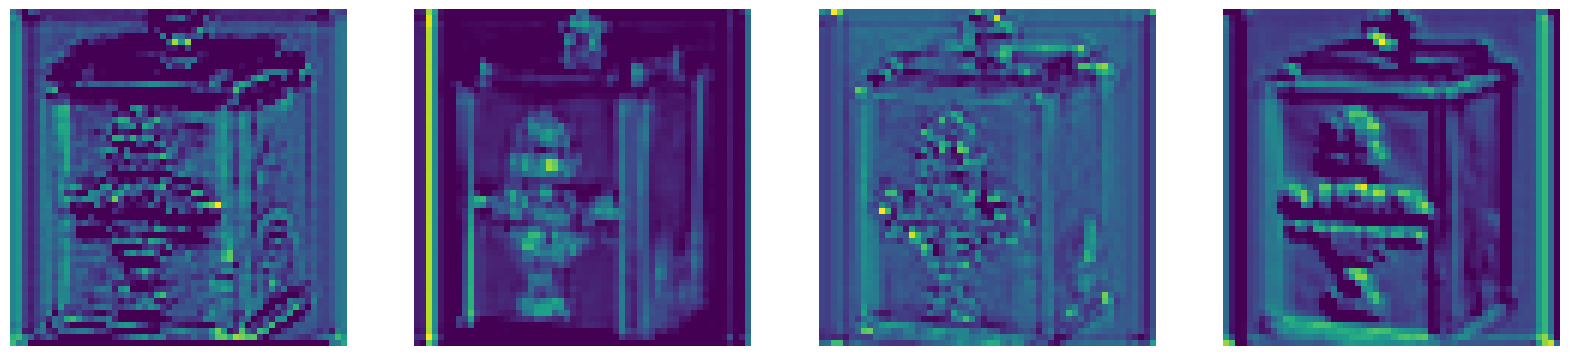

In [56]:
feature_maps = []

def get_features(module, input, output):
    feature_maps.append(output.detach().cpu().numpy())

hook = list(model.children())[4][-1].register_forward_hook(get_features)

inputs = tensor_image.to(device) 

model.eval()
with torch.no_grad():
    _ = model(inputs)

# Отключаем хук
hook.remove()

feature_map = feature_maps[0][0]

fig, axes = plt.subplots(1, min(4, feature_map.shape[0]), figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(feature_map[i], cmap='viridis')
    ax.axis('off')
plt.show()

In [61]:
def create_grad_cam(path):
    target_layers = [list(model.children())[4][-1]]
    image_path = path
    tensor_image = image_to_tensor(image_path)
    tensor_image = tensor_image.to(device)

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=device)

    img = np.array(Image.open(image_path))
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255


    targets = [ClassifierOutputTarget(1)]

    grayscale_cam = cam(input_tensor=tensor_image, targets=targets)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    cam = np.uint8(255*grayscale_cam[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*img), cam , visualization))
   
    return Image.fromarray(images)

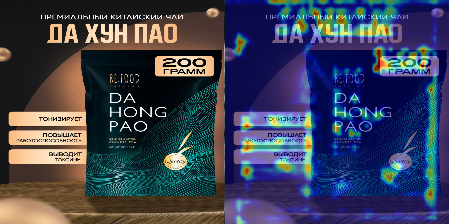

In [62]:
create_grad_cam('C:/Users/senia/Desktop/wb sphere analysis/images/1/540.jpg')

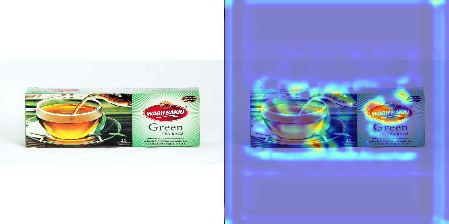

In [63]:
create_grad_cam('C:/Users/senia/Desktop/wb sphere analysis/images/0/120.jpg')

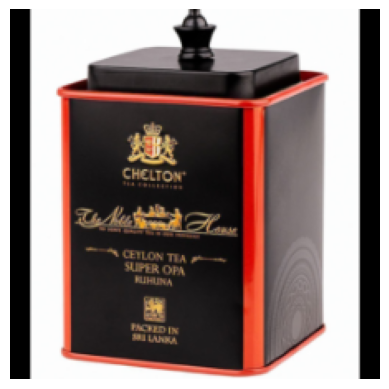

In [49]:
target_layers = [model.layer4[-1]]
input_tensor = tensor_image
img = input_tensor[0]

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = img.permute(1, 2, 0).numpy()  # Преобразуем CxHxW в HxWxC для отображения
img = std * img + mean  # Обратное масштабирование
img = np.clip(img, 0, 1)  # Ограничиваем значения, чтобы они были в диапазоне [0, 1]


plt.imshow(img)
plt.axis('off')  # Не показываем оси для чистоты изображения
plt.show()



In [201]:
target_layers = [list(model.children())[4][-1]]
input_tensor = next(iter(train_load))[0]


# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=device)


targets = [ClassifierOutputTarget(1)]
img = np.array(Image.open('C:/Users/senia/Desktop/wb sphere analysis/images/0/50.jpg'))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
cam_image = show_cam_on_image(img, grayscale_cam[0, :], use_rgb=True)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)


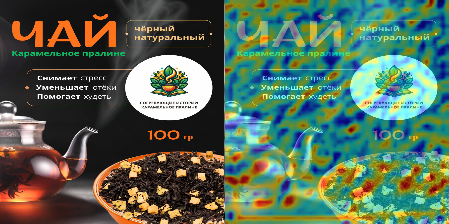

In [202]:
cam = np.uint8(255*grayscale_cam[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [19]:
model = torch.load('cvResNet.pth')

In [23]:
import torch.onnx
x = tensor_image
torch.onnx.export(model, x, 'model.onnx')

## evaluation function

In [20]:
model = torch.load('cvResNet.pth')
model = model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
model.eval()

true_labels = []
predictions = []
all_probas = []

for images, labels in test_loader:
    images = images.to(device)  
    labels = labels.to(device)
    
    with torch.no_grad():  
        outputs = model(images)
        probas = y_probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)  

    all_probas.extend(y_probs.cpu().numpy())
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)
all_probas = np.array(all_probas)

accuracy = accuracy_score(true_labels, predictions)

f1 = f1_score(true_labels, predictions, average='macro')

roc_auc = roc_auc_score(true_labels, all_probas[:,1])

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')


Accuracy: 0.831858407079646
F1 Score: 0.8200033534540576
ROC AUC: 0.899127140974967


## ROC AUC

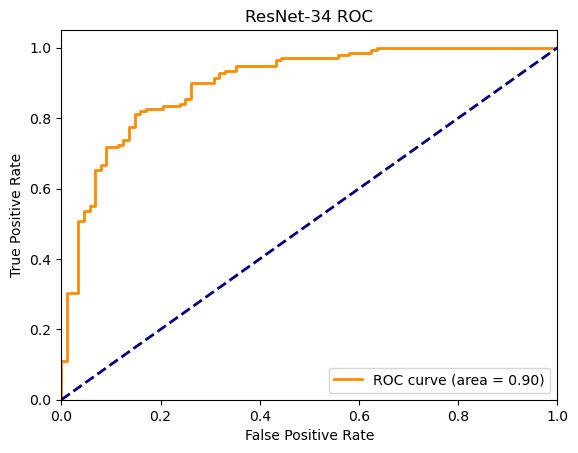

In [49]:
fpr, tpr, thresholds = roc_curve(true_labels, all_probas[:,1])

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet-34 ROC')
plt.legend(loc="lower right")
plt.show()

In [45]:
predictions

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0], dtype=int64)

## Confusion matrix

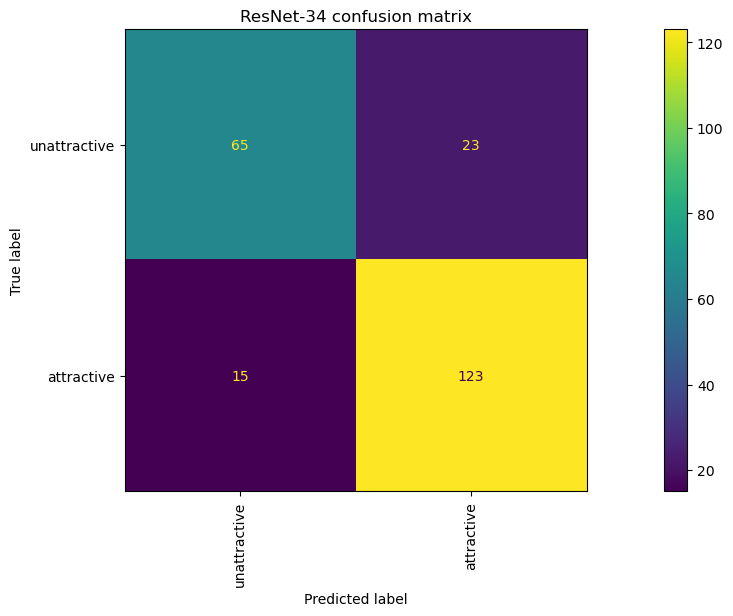

In [50]:
cm = confusion_matrix(true_labels, predictions)
# mapped_labels = [map[label] for label in sorted(map.keys())]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['unattractive', 'attractive'])
fig, ax = plt.subplots(figsize=(20, 6))
disp.plot(ax=ax) 
plt.title('ResNet-34 confusion matrix')
plt.xticks(rotation=90)

plt.show()

## Другие модели, которые показали плохой рез

In [32]:
model = models.alexnet(pretrained=True)

model.classifier[6] = nn.Linear(4096, 2)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\senia/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 43.3MB/s] 


In [33]:
lr = [0.00007]

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l,
        model=model,
        optimizer=optim.Adam,
        n_epochs=5,
        verbose=True,
        scheduler_gamma=1
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

Train loss: 0.007167153991758823
Train acc: 0.8962500095367432
Train f1: 0.9048960860846873
Train f1 global: 0.923102147364758
Val loss: 0.019362594932317734
Val acc: 0.671875
Val f1: 0.7580933461525565
Val f1 global: 0.7137999397909652
Val ROC AUC: 0.8386363636363637


ValueError: too many values to unpack (expected 8)

In [25]:
model = models.vgg16(pretrained=True)

# for param in model.parameters():
#   param.requires_grad = False

# num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 1024),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(1024, 2),
#     nn.Softmax()
# )
model.classifier[6] = nn.Linear(4096,2)
# model

In [34]:
model = torch.load('cvResNet.pth')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
lr = [0.00007]

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l,
        model=model,
        optimizer=optim.Adam,
        n_epochs=10,
        verbose=True,
        scheduler_gamma=1
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

Train loss: 0.006768149323761463
Train acc: 0.9024999737739563
Train f1: 0.9094430562694594
Train f1 global: 0.9063952240537911
Val loss: 0.03775971382856369
Val acc: 0.6484375
Val f1: 0.6719751959017296
Val f1 global: 0.6829349418443852


KeyboardInterrupt: 

In [ ]:
model = models.densenet161(pretrained=True)
model.classifier = nn.Linear(2208, 2)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 146MB/s]


In [ ]:
lr = [0.0001]

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l,
        model=model,
        optimizer=optim.Adam,
        n_epochs=5,
        verbose=True,
        scheduler_gamma=1
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

Train loss: 0.0046640243381261826
Train acc: 0.9471153616905212
Train f1: 0.9647329163484178
Train f1 global: 0.9711214767061479
Val loss: 0.0437251515686512
Val acc: 0.6015625
Val f1: 0.6566660132151984
Val f1 global: 0.656519221060585


{0.0001: (0.0046640243381261826,
  0.9471153616905212,
  0.9647329163484178,
  0.9711214767061479,
  0.0437251515686512,
  0.6015625,
  0.6566660132151984,
  0.656519221060585)}

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.fc = nn.Linear(2048,2)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 141MB/s]


In [ ]:
lr = [0.0001]

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l,
        model=model,
        optimizer=optim.Adam,
        n_epochs=5,
        verbose=True,
        scheduler_gamma=1
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

Training, epoch 0, lr: 0.0001:   0%|          | 0/26 [00:00<?, ?it/s]

RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [ ]:
# model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model = models.vit_b_32(pretrained=True)
model.heads[0] = nn.Linear(768, 2)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:03<00:00, 90.1MB/s]


In [ ]:
lr = [0.0001]

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l,
        model=model,
        optimizer=optim.Adam,
        n_epochs=5,
        verbose=True,
        scheduler_gamma=1
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

Train loss: 0.020827390253543854
Train acc: 0.6911057829856873
Train f1: 0.6862502172792
Train f1 global: 0.6970363473758544
Val loss: 0.02315382845699787
Val acc: 0.6328125
Val f1: 0.6817782091219592
Val f1 global: 0.6701428931535487


{0.0001: (0.020827390253543854,
  0.6911057829856873,
  0.6862502172792,
  0.6970363473758544,
  0.02315382845699787,
  0.6328125,
  0.6817782091219592,
  0.6701428931535487)}

In [ ]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model.classifier.fc = nn.Linear(1280, 2)

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/efficientnet_b0_pyt_amp/versions/20.12.0/files/nvidia_efficientnet-b0_210412.pth" to /root/.cache/torch/hub/checkpoints/nvidia_efficientnet-b0_210412.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 75.6MB/s]


In [ ]:
lr = [0.0001]

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l,
        model=model,
        optimizer=optim.Adam,
        n_epochs=5,
        verbose=True,
        scheduler_gamma=1
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

Train loss: 0.012146726250648499
Train acc: 0.870192289352417
Train f1: 0.889578314900857
Train f1 global: 0.8857647352269191
Val loss: 0.02650446817278862
Val acc: 0.6328125
Val f1: 0.6749622491809991
Val f1 global: 0.6666928542124383


{0.0001: (0.012146726250648499,
  0.870192289352417,
  0.889578314900857,
  0.8857647352269191,
  0.02650446817278862,
  0.6328125,
  0.6749622491809991,
  0.6666928542124383)}

In [ ]:
class ResNetWithDropout(nn.Module):
    def __init__(self, n_classes=6, dropout_prob=0.5):
        super(ResNetWithDropout, self).__init__()
        resnet = models.resnet101(pretrained=False)

        # remove the original fully connected layer
        modules = list(resnet.children())[:-1]
        self.features = nn.Sequential(*modules)

        # add a new fully connected layer with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(resnet.fc.in_features, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
lr = [0.00007]
model = ResNetWithDropout()

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l,
        model=model,
        optimizer=optim.Adam,
        n_epochs=2,
        verbose=False,
        scheduler_gamma=1
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

{7e-05: (0.023122061043977737,
  0.645432710647583,
  0.5950344881775546,
  0.598869621642459,
  0.0212582778185606,
  0.6302083134651184,
  0.5774837825251415,
  0.5914129283648762)}